In [44]:
#import libraries/packages
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


### Problem Statement

As a company, CitiBike, we need to increase our accuracy of predicting the next weeks total rides by Members and Product Type so that we can better forecast our future revenue due to the unpredictable nature of weather impact on our revenue.

We need 3 years of data with the following fields:
<ul>
  <li>Date</li>
  <li>Ride Cat</li>
  <li>Rides</li>
  <li>Weather Car</li>
  <li>Min Temp</li>
  <li>Max Temp</li>
  <li>Freezing Flag</li>
  <li>Heat Flag</li>
  <li>Weekend Flag</li>
  <li>Holiday Flag</li>
</ul>

# IMPORT THE DATA & EDA

In [2]:
#Bring in Data from ML_Data_Model.ipynb 
df = pd.read_csv('final_ml_data.csv')
df['DATE'] =  pd.to_datetime(df['DATE'])
df.head(4)

,DATE,RIDE_TYPE,RIDES,PRCP,SNOW,TMAX,TMIN
0,2022-01-01,classic_bikecasual,3362,0.76,0.0,57.0,50.0
1,2022-01-01,classic_bikemember,8233,0.76,0.0,57.0,50.0
2,2022-01-01,electric_bikecasual,3227,0.76,0.0,57.0,50.0
3,2022-01-01,electric_bikemember,5941,0.76,0.0,57.0,50.0


In [3]:
# Check null values and datatypes
print(f"MIN DATE: {df['DATE'].min()}")
print(f"MAX DATE: {df['DATE'].min()}")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   DATE       2920 non-null   datetime64[ns]
 1   RIDE_TYPE  2920 non-null   object        
 2   RIDES      2920 non-null   int64         
 3   PRCP       2920 non-null   float64       
 4   SNOW       2920 non-null   float64       
 5   TMAX       2920 non-null   float64       
 6   TMIN       2920 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 159.8+ KB


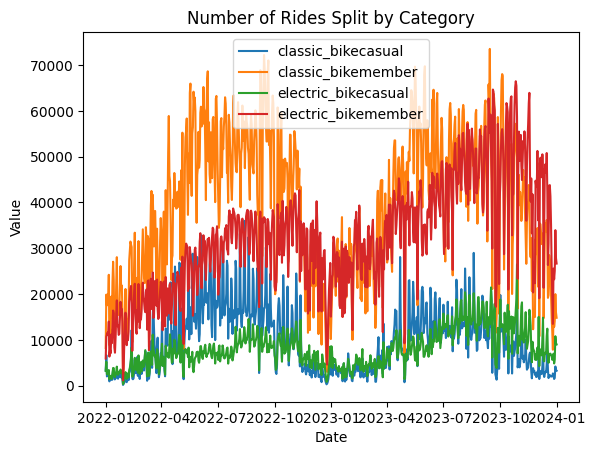

In [4]:
# Plot each different category type daily
fig, ax = plt.subplots()

# Iterate through each category and plot the lines
for category in df['RIDE_TYPE'].unique():
    df_category = df[df['RIDE_TYPE'] == category]
    ax.plot(df_category['DATE'], df_category['RIDES'], label=category)

# Add title, labels, and legend
ax.set_title('Number of Rides Split by Category')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()

# Show the plot
plt.show()

In [5]:
# Aggregate to Monthly Level 
df_monthly =  df.groupby([pd.Grouper(key='DATE', freq='M'), 'RIDE_TYPE']).sum('RIDES')
df_monthly = df_monthly.reset_index()
df_monthly.head(2)

/var/folders/d2/8_sjl_k56djc0380jpk4qxrc0000gn/T/ipykernel_31987/3016276037.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly =  df.groupby([pd.Grouper(key='DATE', freq='M'), 'RIDE_TYPE']).sum('RIDES')


,DATE,RIDE_TYPE,RIDES,PRCP,SNOW,TMAX,TMIN
0,2022-01-31,classic_bikecasual,65454,3.76,20.4,1192.0,772.0
1,2022-01-31,classic_bikemember,523443,3.76,20.4,1192.0,772.0


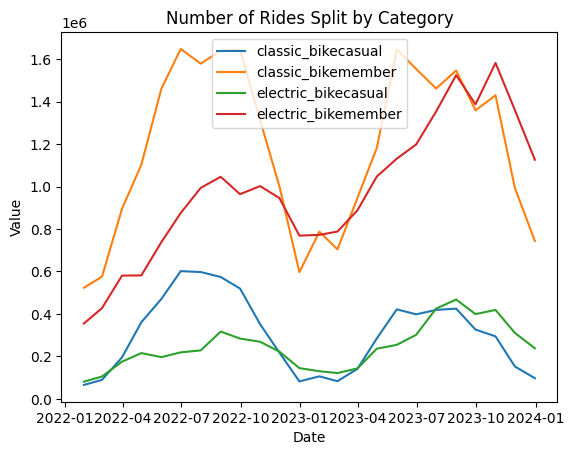

In [6]:
# Plot each different category type monthly
fig, ax = plt.subplots()

# Iterate through each category and plot the lines
for category in df_monthly['RIDE_TYPE'].unique():
    df_category = df_monthly[df_monthly['RIDE_TYPE'] == category]
    ax.plot(df_category['DATE'], df_category['RIDES'], label=category)

# Add title, labels, and legend
ax.set_title('Number of Rides Split by Category')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()

# Show the plot
plt.show()

## EDA SUMMARY

The data is showing some visual seasonality where Summer Month have an increase or peak amount of rides.

There are no null values.

Member Rides seem to be more popular throughout all the data. Classic bikes are mostly more popular than electric bikes, but in the winter electric bikes seems to overtake Classic bikes in terms of number of rides per day. 

"Ridership" of electric bikes has visually increased on a monthly basis in 2023 compared to 2022. 

**We do not know the following: how much supply has increased, any technology improvements, pricing structure changes, company initiatives, etc. We can't really know what *caused* changes in trends. Since we want to predict 7 days in the future, so it is important to understand what has happenend in the past. Online research could improve exogenous feature inclusions.**

*should do some additional QA checks just to be sure everything is clean*

# MODELING

For modeling I will explore the following and iterate as more information is discovered>

1. **BASELINE** Split by 4 categories and find the best ARMA model optimized using AIC Loss Funciton
2. **SARIMA** If seasonality is identified, we can use SARIMA
3. **INCLUDE WEATHER FEATURES** Include Weather Features to model
4. **INCLUDE DATE FEATURES** Include date features; like holidays, weekends, seasons, etc.
5. **TREE BASED MODELS**

### BASELINE

In [7]:
# SPLIT THE DATA INTO 4 SEGMENTS
df_member_elec = df[df['RIDE_TYPE'] == 'electric_bikemember']
df_memeber_reg = df[df['RIDE_TYPE'] == 'classic_bikemember']
df_casual_elec = df[df['RIDE_TYPE'] == 'electric_bikecasual']
df_casual_reg = df[df['RIDE_TYPE'] == 'classic_bikecasual']
list_dfs = [df_member_elec, df_memeber_reg, df_casual_elec, df_casual_reg] ## ADD dfs TO A LIST

['electric_bikemember']


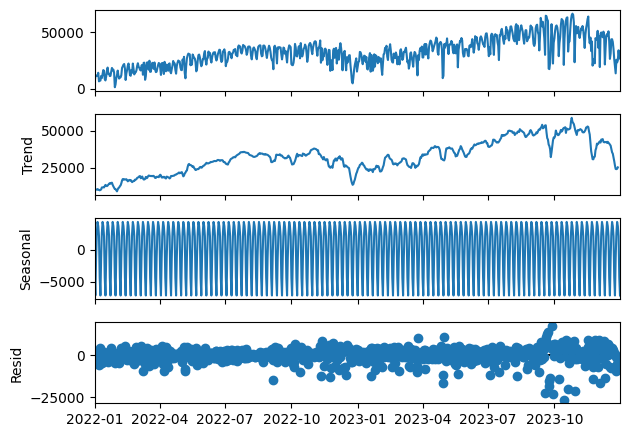

['classic_bikemember']


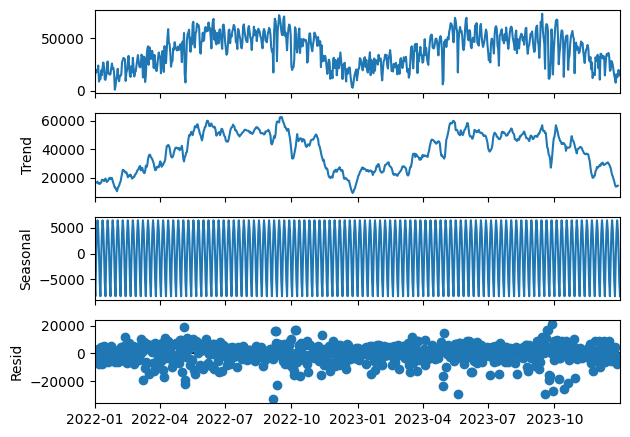

['electric_bikecasual']


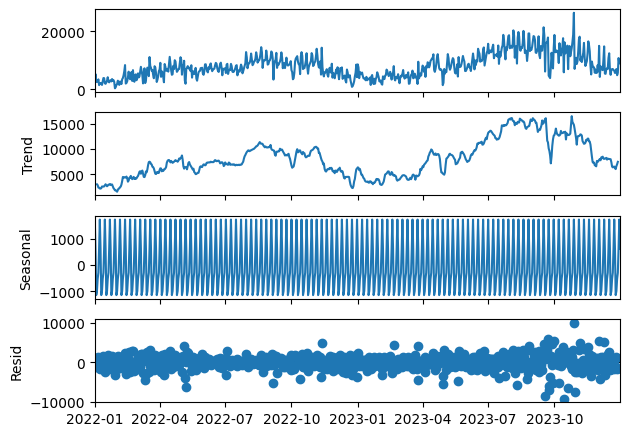

['classic_bikecasual']


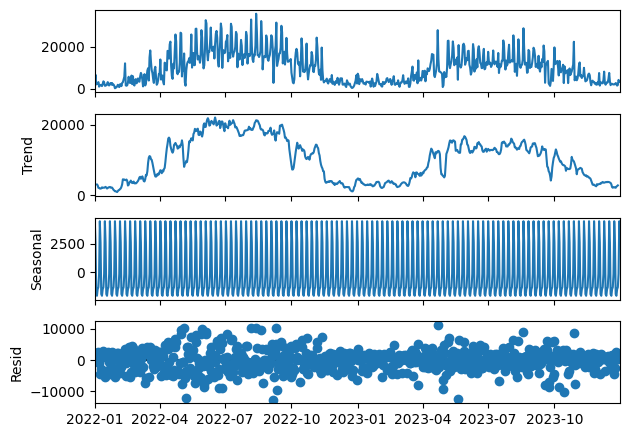

In [9]:
## Show Decomposition for Each Category
for i in list_dfs:
    title = i['RIDE_TYPE'].unique()
    i = i.iloc[:,[0,2]]
    i.set_index('DATE', inplace=True)  
    result = seasonal_decompose(i)
    fig = result.plot()
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()  # Adjust layout to make room for the title
    plt.subplots_adjust(top=0.9)  # Adjust the top margin to fit the title
    plt.show()

**Appears to be weekly seasonality for each category and definitely not stationary, but we will usd ADF to test.**

In [25]:
# Run ADF test for stationary checks. 
sationary_list = []
for data in list_dfs:
    adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(data['RIDES'].values)
    if pval < .05:
        sationary_list.append(1)
    else:
        sationary_list.append(0)
    print(data['RIDE_TYPE'].unique())
    print('ADF test statistic:', adf)
    print('ADF p-values:', pval)
    print('ADF number of lags used:', usedlag)
    print('ADF number of observations:', nobs)
    print('ADF critical values:', crit_vals)
    print('ADF best information criterion:', icbest)


['electric_bikemember']
ADF test statistic: -2.0087416718493762
ADF p-values: 0.282753383401943
ADF number of lags used: 20
ADF number of observations: 709
ADF critical values: {'1%': -3.439606888036868, '5%': -2.865625121924057, '10%': -2.5689454046801052}
ADF best information criterion: 14304.204090538484
['classic_bikemember']
ADF test statistic: -1.6181081977902876
ADF p-values: 0.47372123581288983
ADF number of lags used: 20
ADF number of observations: 709
ADF critical values: {'1%': -3.439606888036868, '5%': -2.865625121924057, '10%': -2.5689454046801052}
ADF best information criterion: 14811.24901996233
['electric_bikecasual']
ADF test statistic: -1.8404121362468902
ADF p-values: 0.360590672872207
ADF number of lags used: 20
ADF number of observations: 709
ADF critical values: {'1%': -3.439606888036868, '5%': -2.865625121924057, '10%': -2.5689454046801052}
ADF best information criterion: 12949.49277792879
['classic_bikecasual']
ADF test statistic: -1.2701494416899382
ADF p-value

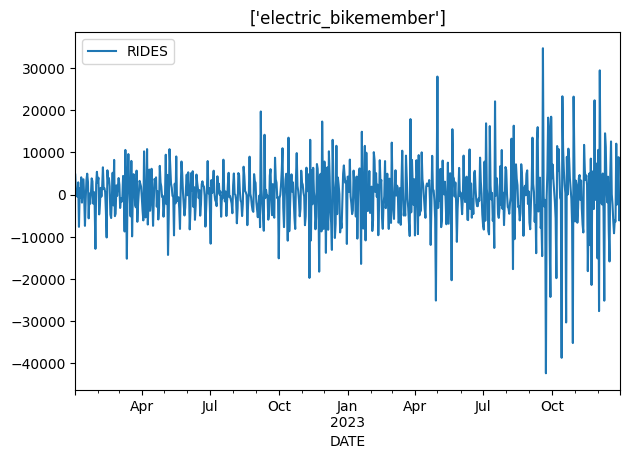

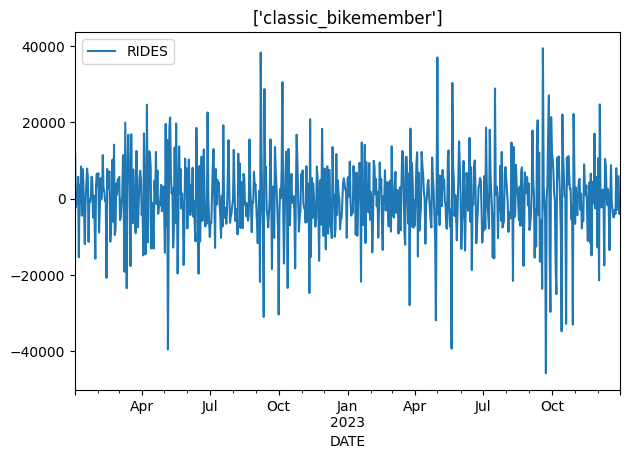

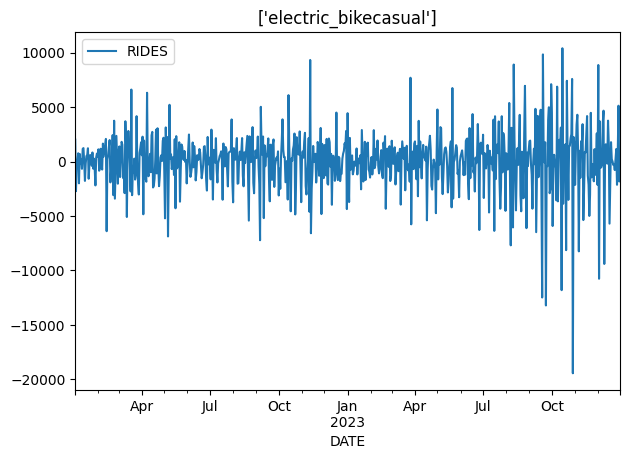

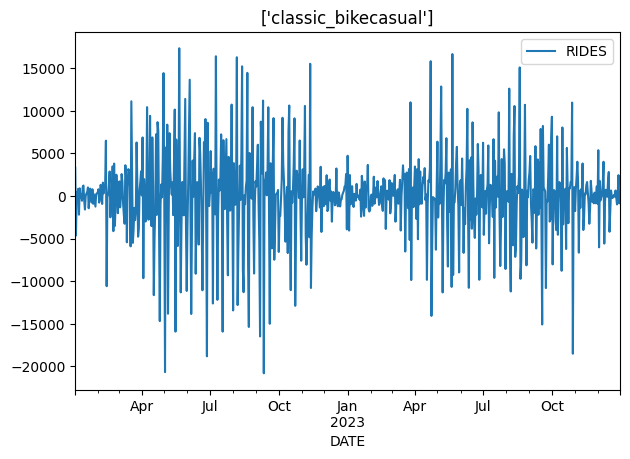

In [26]:
## Show Difference 1 for Each Category
for data in list_dfs:
    title = data['RIDE_TYPE'].unique()
    data = data.iloc[:,[0,2]]
    data.set_index('DATE', inplace=True)  
    diff_values = data.diff().dropna()
    fig = diff_values.plot()
    plt.tight_layout()
    plt.title(title)  # Adjust layout to make room for the title
    plt.subplots_adjust(top=0.9)  # Adjust the top margin to fit the title
    plt.show()

In [27]:
for data in list_dfs:
    print(data['RIDE_TYPE'].unique())
    data = data['RIDES']
    differenced_series = data.diff().dropna()
    adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(differenced_series)
    print('ADF test statistic:', adf)
    print('ADF p-values:', pval)
    print('ADF number of lags used:', usedlag)
    print('ADF number of observations:', nobs)
    print('ADF critical values:', crit_vals)
    print('ADF best information criterion:', icbest)

['electric_bikemember']
ADF test statistic: -8.843097806607057
ADF p-values: 1.6481070756792267e-14
ADF number of lags used: 20
ADF number of observations: 708
ADF critical values: {'1%': -3.439620010600208, '5%': -2.8656309041017756, '10%': -2.5689484851894413}
ADF best information criterion: 14284.468167976958
['classic_bikemember']
ADF test statistic: -9.077747460706801
ADF p-values: 4.1349769705723554e-15
ADF number of lags used: 20
ADF number of observations: 708
ADF critical values: {'1%': -3.439620010600208, '5%': -2.8656309041017756, '10%': -2.5689484851894413}
ADF best information criterion: 14791.856260746143
['electric_bikecasual']
ADF test statistic: -8.051824458682749
ADF p-values: 1.7338078919956394e-12
ADF number of lags used: 20
ADF number of observations: 708
ADF critical values: {'1%': -3.439620010600208, '5%': -2.8656309041017756, '10%': -2.5689484851894413}
ADF best information criterion: 12932.215337776499
['classic_bikecasual']
ADF test statistic: -8.5998293977113

#### With Differencing by 1, we acheive stationariy ADF p-val <.05 and ADF test stat below critical values

#### Thus, we will proceed with out baseline model as an ARIMA with 1 difference for parameter d

In [107]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error



['electric_bikemember']


<Figure size 1600x300 with 0 Axes>

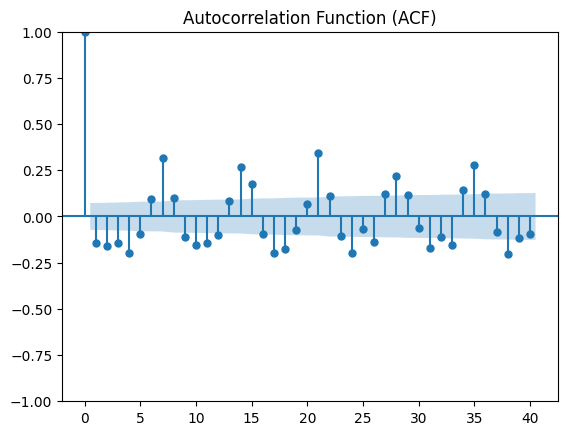

<Figure size 1600x300 with 0 Axes>

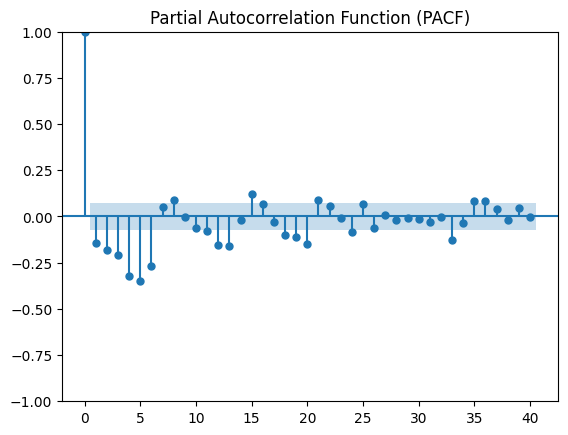

['classic_bikemember']


<Figure size 1600x300 with 0 Axes>

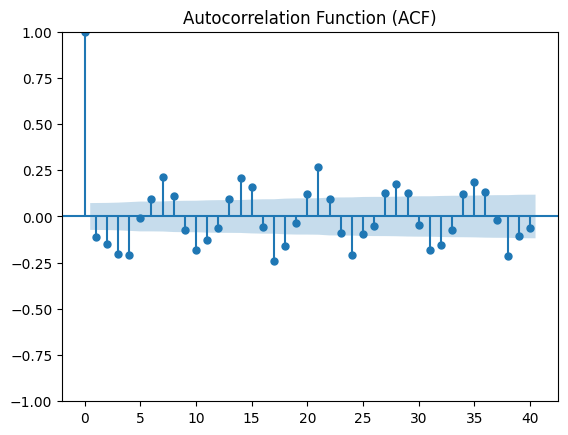

<Figure size 1600x300 with 0 Axes>

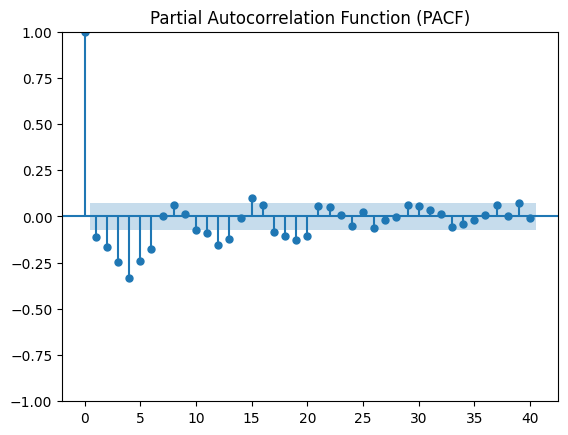

['electric_bikecasual']


<Figure size 1600x300 with 0 Axes>

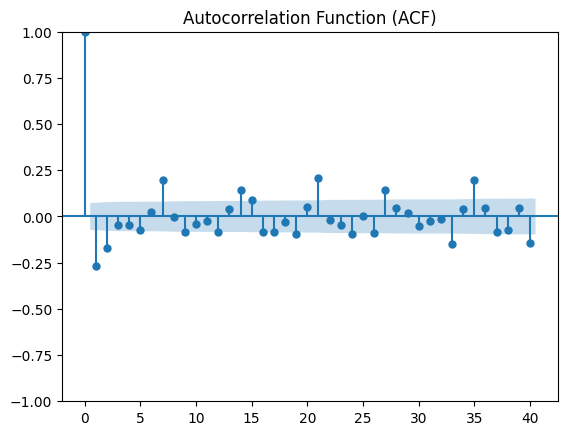

<Figure size 1600x300 with 0 Axes>

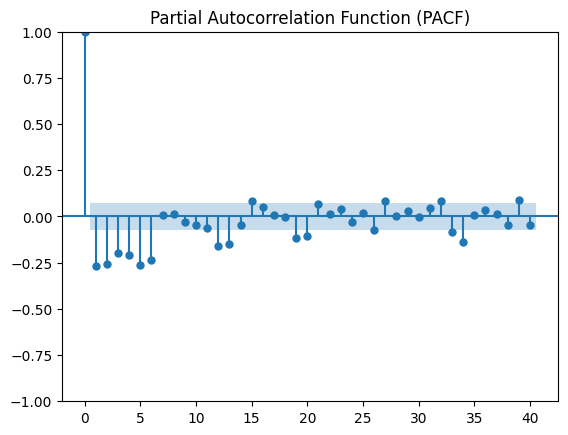

['classic_bikecasual']


<Figure size 1600x300 with 0 Axes>

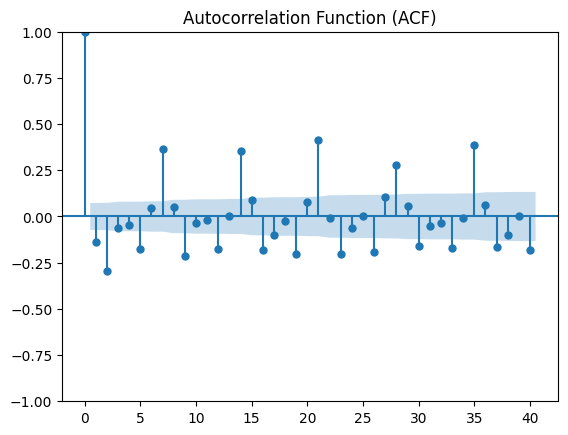

<Figure size 1600x300 with 0 Axes>

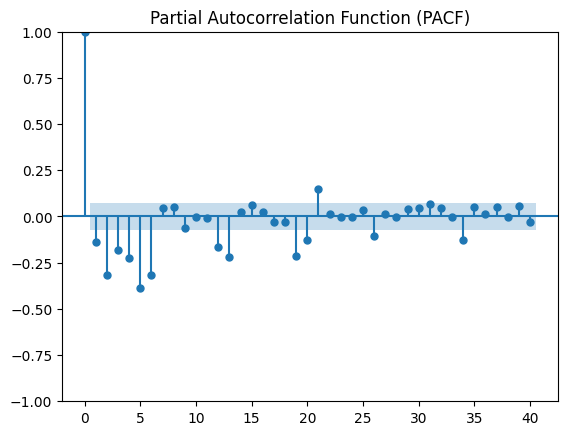

In [36]:
## Plot ACF and PACF
for data in list_dfs:
    title = data['RIDE_TYPE'].unique()
    data = data.iloc[:,[0,2]]
    data.set_index('DATE', inplace=True)  
    diff_values = data.diff().dropna()
    print(title)

    # Plot ACF
    plt.figure(figsize=(16, 3))
    plot_acf(diff_values, lags=40, alpha=0.05)
    plt.title('Autocorrelation Function (ACF)')
    plt.show()

    # Plot PACF
    plt.figure(figsize=(16, 3))
    plot_pacf(diff_values, lags=40, alpha=0.05, method='ywm')  # Use "ywm" for compatibility with differenced data
    plt.title('Partial Autocorrelation Function (PACF)')
    plt.show()


In [119]:
# Training and test split for 7-day prediction
data = list_dfs[0].iloc[:,[0,2]]
data.set_index('DATE', inplace=True)  

train = data[:-7]
test = data[-7:]
test

,RIDES
DATE,
2023-12-25,13490
2023-12-26,25575
2023-12-27,23227
2023-12-28,25071
2023-12-29,33954
2023-12-30,27829
2023-12-31,26666


In [120]:
model = ARIMA(train, order=(3,2,1))  
fitted_model = model.fit()
fitted_model.summary()

/Users/westonshuken/anaconda3/envs/usual/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/westonshuken/anaconda3/envs/usual/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/westonshuken/anaconda3/envs/usual/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  RIDES   No. Observations:                  723
Model:                 ARIMA(3, 2, 1)   Log Likelihood               -7417.910
Date:                Fri, 27 Dec 2024   AIC                          14845.820
Time:                        12:35:24   BIC                          14868.723
Sample:                    01-01-2022   HQIC                         14854.661
                         - 12-24-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2069      0.028     -7.303      0.000      -0.262      -0.151
ar.L2         -0.2183      0.036     -6.142      0.000      -0.288      -0.149
ar.L3         -0.2095      0.036     -5.839      0.000      -0.280      -0.139
ma.L1         -1.0000      0.028    -35.185      0.000      -1.056      -0.944
sigma2      5.013e+07   5.67e-10   8.84e+16      0.000    5.01e+07    5.01e+07
===================================================================================
Ljung-Box (L1) (Q):                   3.40   Jarque-Bera (JB):               863.01
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               5.08   Skew:                            -0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.61e+31. Standard errors may be unstable.
"""

In [121]:
# Forecasting the next 7 days
forecast = fitted_model.forecast(steps=7)

# Convert to Series for comparison
forecast_series = pd.Series(forecast, index=test.index)
forecast_series

DATE
2023-12-25    24510.512193
2023-12-26    26862.035346
2023-12-27    26698.635623
2023-12-28    25304.173738
2023-12-29    25188.079047
2023-12-30    25603.212544
2023-12-31    25887.245941
Name: predicted_mean, dtype: float64

In [127]:
print(test.sum())
print(forecast.sum())
print(forecast.sum()-test.sum())
print((forecast.sum()-test.sum())/test.sum())

RIDES    175812
dtype: int64
180053.894433653
RIDES    4241.894434
dtype: float64
RIDES    0.024127
dtype: float64


In [128]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, forecast_series))
mape = mean_absolute_percentage_error(test, forecast)

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

print(test.sum())
print(forecast.sum())
print(forecast.sum()-test.sum())
print('Weekly Percent Forecast Diff',(forecast.sum()-test.sum())/test.sum())

RMSE: 5575.670756714464
MAPE: 0.199054965729478
RIDES    175812
dtype: int64
180053.894433653
RIDES    4241.894434
dtype: float64
Weekly Percent Forecast Diff RIDES    0.024127
dtype: float64


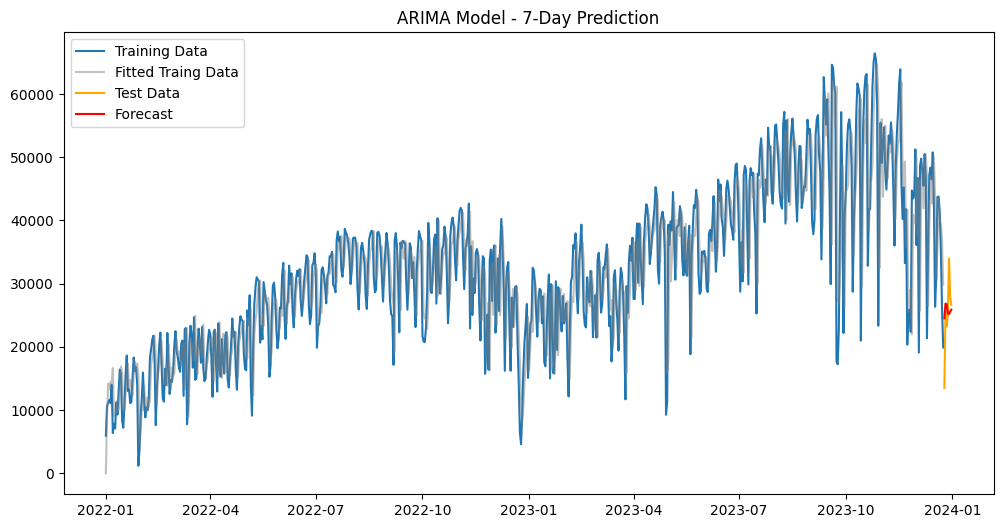

In [130]:
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(fitted_model.fittedvalues, label='Fitted Traing Data', color='gray', alpha=.5)
plt.plot(test, label='Test Data', color='orange')
plt.plot(forecast_series, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Model - 7-Day Prediction')
plt.show()

In [89]:
import itertools
# Define parameter ranges
p = range(0, 8)  # Autoregressive terms
d = range(1, 2)  # Differencing terms
q = range(0, 8)  # Moving average terms

# Create all possible combinations
pdq_combinations = list(itertools.product(p, d, q))

In [109]:
data = list_dfs[0].iloc[:,[0,2]]
data.set_index('DATE', inplace=True)  

# Store results
best_aic = float('inf')  # Initialize with a very high value
best_params = None       # Placeholder for best parameters
results = []

for param in pdq_combinations:
    try:
        # Fit ARIMA model
        model = ARIMA(data, order=param)
        fitted_model = model.fit()

        # Forecast the test period
        forecast = fitted_model.forecast(steps=len(test))
        
        # Calculate MAPE
        mape = mean_absolute_percentage_error(test, forecast)
        results.append((param, mape))

        # Update best parameters
        if mape < best_mape:
            best_mape = mape
            best_params = param
    except Exception as e:
        # Handle cases where model fitting fails
        continue

/Users/westonshuken/anaconda3/envs/usual/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/westonshuken/anaconda3/envs/usual/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/westonshuken/anaconda3/envs/usual/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/westonshuken/anaconda3/envs/usual/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/westonshuken/anaconda3/envs/usual/lib/python3.11/site-packages/st

In [114]:
results.sort(key=lambda x: x[1])
results[:5]

[((3, 1, 2), 0.29802908646922915),
 ((6, 1, 0), 0.3083939179641539),
 ((6, 1, 1), 0.3112897161876608),
 ((7, 1, 1), 0.3126197170622964),
 ((7, 1, 0), 0.31358069335191213)]

In [90]:
data = list_dfs[0].iloc[:,[0,2]]
data.set_index('DATE', inplace=True)  

# Store results
best_aic = float('inf')  # Initialize with a very high value
best_params = None       # Placeholder for best parameters
results = []

for param in pdq_combinations:
    try:
        # Fit ARIMA model
        model = ARIMA(data, order=param)
        fitted_model = model.fit()
        
        # Record AIC
        aic = fitted_model.aic
        results.append((param, aic))

        # Update best parameters
        if aic < best_aic:
            best_aic = aic
            best_params = param
    except Exception as e:
        # Handle cases where model fitting fails
        continue

/Users/westonshuken/anaconda3/envs/usual/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/westonshuken/anaconda3/envs/usual/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/westonshuken/anaconda3/envs/usual/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/westonshuken/anaconda3/envs/usual/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/westonshuken/anaconda3/envs/usual/lib/python3.11/site-packages/st

In [91]:
# Sort results by AIC
results.sort(key=lambda x: x[1])
print(f"Best ARIMA parameters: {best_params} with AIC: {best_aic}")
print("Top 5 Results:")
for param, aic in results[:5]:
    print(f"ARIMA{param} - AIC: {aic}")

Best ARIMA parameters: (5, 1, 7) with AIC: 14677.255242466628
Top 5 Results:
ARIMA(5, 1, 7) - AIC: 14677.255242466628
ARIMA(6, 1, 6) - AIC: 14680.391743935716
ARIMA(6, 1, 7) - AIC: 14687.500636882309
ARIMA(5, 1, 6) - AIC: 14693.011719487455
ARIMA(3, 1, 7) - AIC: 14699.963809456585


In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['ride_id'].diff().dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['ride_id'].diff().dropna(), lags=40, ax=ax2)
plt.show()

In [ ]:
decomposition = sm.tsa.seasonal_decompose(df['ride_id'], model='additive', period=1)

# Plot the decomposition
decomposition.plot()
plt.show()

## Monthly

In [ ]:
monthly_rides = df.resample('M').sum()


In [ ]:
monthly_rides['ride_id'].plot()

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(monthly_rides['ride_id'].diff().dropna(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(monthly_rides['ride_id'].diff().dropna(), lags=10, ax=ax2)
plt.show()

In [ ]:
decomposition = sm.tsa.seasonal_decompose(monthly_rides['ride_id'], model='additive', period=1)

# Plot the decomposition
decomposition.plot()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(monthly_rides['ride_id'])
print(f'p-value: {result[1]}')

In [ ]:
model = sm.tsa.ARIMA(monthly_rides['ride_id'], order=(4, 12, 1))
fitted_model = model.fit()

# Print AIC and BIC
print(f'AIC: {fitted_model.aic}')
print(f'BIC: {fitted_model.bic}')
fitted_model.summary()

In [ ]:
model = sm.tsa.ARIMA(df['ride_id'], order=(4, 1, 1))
fitted_model = model.fit()

fitted_model.summary()

In [ ]:
monthly_rides['ride_id'].diff(4).plot()


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming df['rides'] is the time series with quarterly data
model = SARIMAX(monthly_rides['ride_id'], 
                order=(4, 0, 1),  # non-seasonal ARIMA orders
                seasonal_order=(0, 0, 0, 4))  # quarterly seasonality
model_fit = model.fit()

# Make predictions for the next month
forecast = model_fit.forecast(steps=1)  # Predict the next month's value
forecast

In [ ]:
monthly_rides.plot()

## Zipcode

In [ ]:
df = pd.read_csv("/Users/westonshuken/Documents/_2025/CitiBike/monthly_rides_by_station_2022_2023.csv")
df.head()

In [ ]:
zips = pd.read_csv("/Users/westonshuken/Documents/_2025/CitiBike/stationzipdata.csv")
zips.head()

In [ ]:
df = pd.merge(df, zips, on='end_station_name', how='left')
df.head()

In [ ]:
columns = {'end_station_name':'Station_Name','ended_at':'Date','ride_id':'rides','ZIP Code':'zipcode'}
df = df.rename(columns=columns)
df = df.drop(columns=['end_lng_x', 'end_lat_x','end_lng_y', 'end_lat_y'])

In [ ]:
df = df[df['zipcode'] == '11207']

In [ ]:
df = df.drop(columns=['Station_Name','zipcode'])

In [ ]:
df = df.groupby('Date').sum('rides').reset_index()
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df.set_index('Date', inplace=True)

In [ ]:
df_month = df.resample('M').sum()
df_month.plot()

In [ ]:
df['rides'].plot()